# 滑窗和多边形拟合

在亮度直方图中，选取两个最高峰，作为车道线的起点，然后使用滑动窗口来确定车道线位置

![hello](./histogram.png)

![hello](./slide_windows.jpg)

In [18]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

import matplotlib.image as mpimg

### step1:将直方图分为两部分，每部分一条车道线

(720, 1280) [[1. 1. 1. ... 0. 0. 0.]
 [1. 1. 1. ... 0. 0. 0.]
 [1. 1. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
(720, 1280, 3)
(1280,)


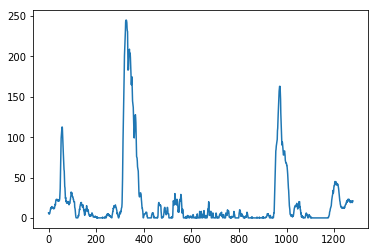

In [19]:

binary_warped = mpimg.imread('warped_example.jpg')/255
print(binary_warped.shape,binary_warped)
# Assuming you have created a warped binary image called "binary_warped"
# Take a histogram of the bottom half of the image
histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
# Create an output image to draw on and visualize the result
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
print(out_img.shape)
# Find the peak of the left and right halves of the histogram
# These will be the starting point for the left and right lines
print(histogram.shape)
plt.plot(histogram)
plt.show()

In [20]:
midpoint = np.int(histogram.shape[0]//2)
print(midpoint)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

640


In [21]:
leftx_base,rightx_base

(327, 971)

### step2: 设置滑窗，窗口参数

In [69]:
# HYPERPARAMETERS
# Choose the number of sliding windows
nwindows = 9
# Set the width of the windows +/- margin
#窗口宽度
margin = 100
# Set minimum number of pixels found to recenter window
#落入窗口的像素个数
minpix = 50 

# Set height of windows - based on nwindows above and image shape
window_height = np.int(binary_warped.shape[0]//nwindows)

# Identify the x and y positions of all nonzero (i.e. activated) pixels in the image
nonzero = binary_warped.nonzero()  #nonzero()返回非零元素的坐标
print(nonzero)
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])

y_low = 100
y_high=500
xleft_low=500
xleft_high=800
good_left_inds = ((nonzeroy >= y_low) & (nonzeroy < y_high) & (nonzerox >= xleft_low) &  (nonzerox < xleft_high)).nonzero()[0]
print(type(nonzero))
print(nonzeroy.shape)
print(len(nonzerox))
print(nonzerox)
print("==="*88)
print(good_left_inds)


# Current positions to be updated later for each window in nwindows
leftx_current = leftx_base
rightx_current = rightx_base

# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []

(array([  0,   0,   0, ..., 719, 719, 719]), array([   0,    1,    2, ..., 1051, 1067, 1069]))
<class 'tuple'>
(89486,)
89486
[   0    1    2 ... 1051 1067 1069]
[64882 64883 64884 64885 64932 64933 64934 64935 64990 64991 64992 65041
 65042 65043 65044]


#### 设置窗口步骤：
1.遍历所有窗口nwindows；

2.找到当前窗口的边界(由leftx_current,rightx_current，margin确定)；

3.用cv2.rectangle()画图；

4.现在知道窗口边界，由nonzerox，nonzeroy确定有多少像素落入窗口中；

5.left_lane_inds and right_lane_inds;

6.if step4中的像素超过hyperparameter minpix，重新定位窗口位置(基于所有像素的中位数)


## Fit a polynomial

In [30]:
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import cv2

# Load our image
binary_warped = mpimg.imread('warped_example.jpg')

In [55]:
def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    
    #step2.找到当前窗口的边界(由leftx_current,rightx_current，margin确定)；
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    
    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    # 标定图像中所有非零的点坐标
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        #step1:确定当前窗口边界
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        #step2:画框
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        
        #step3:统计落入框内点数
        # Identify the nonzero pixels in x and y within the window #
        # good_left_inds:元组的第0个元素，该元素为一个数组，保存非零的索引
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        
        print("good_left_inds",type(good_left_inds))
        print("good_left_inds：",good_left_inds)
        
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # step5:框内点数超过minpix,更新框位置(取lane line像素点平均值作为新的x_current坐标)
        # If you found > minpix pixels, recenter next window on their mean position

        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds])) #nonzerox[good_left_inds]符合条件的x坐标，再求均值
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img

In [70]:
def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)
    
     ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]
    
    mpimg.imsave('rectangle_line.png',out_img)
    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

   

    # Plots the left and right polynomials on the lane lines
    plt.plot(left_fitx, ploty, color='red')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.show()

    return out_img

good_left_inds <class 'numpy.ndarray'>
good_left_inds： [82135 82136 82137 ... 89382 89383 89384]
good_left_inds <class 'numpy.ndarray'>
good_left_inds： [71398 71399 71400 ... 82048 82049 82050]
good_left_inds <class 'numpy.ndarray'>
good_left_inds： [63608 63609 63610 ... 71368 71369 71370]
good_left_inds <class 'numpy.ndarray'>
good_left_inds： [53979 53980 53981 ... 63589 63590 63591]
good_left_inds <class 'numpy.ndarray'>
good_left_inds： [43839 43840 43841 ... 53821 53822 53823]
good_left_inds <class 'numpy.ndarray'>
good_left_inds： [35496 35497 35498 ... 43812 43813 43814]
good_left_inds <class 'numpy.ndarray'>
good_left_inds： [27226 27227 27228 ... 35447 35448 35449]
good_left_inds <class 'numpy.ndarray'>
good_left_inds： [14706 14707 14708 ... 27159 27160 27161]
good_left_inds <class 'numpy.ndarray'>
good_left_inds： [   77    78    79 ... 14619 14620 14621]


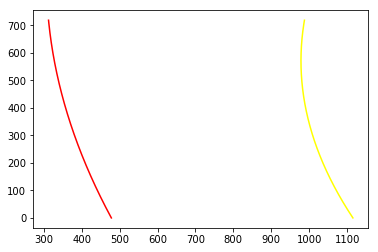

In [71]:
out_img = fit_polynomial(binary_warped)

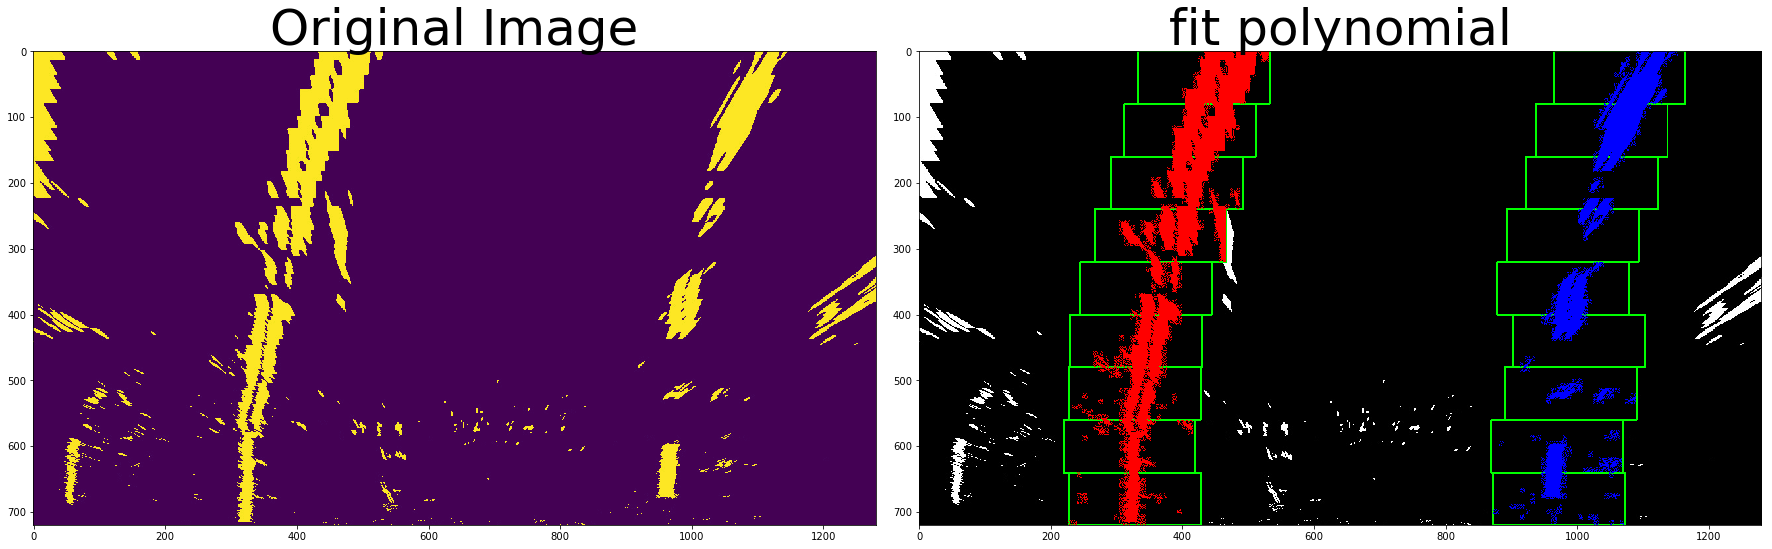

In [72]:
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(binary_warped)
ax1.set_title('Original Image', fontsize=50)

ax2.imshow(out_img)
ax2.set_title('fit polynomial', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()